In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import datetime
import matplotlib.pyplot as plt
import typing as tp

from collections import Counter
from datetime import datetime
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

RANDOM_SEED = 47

In [2]:
def get_full_raw_data() -> pd.DataFrame:
    """ Функция чтения и первичного препроцессинга исходных данных
    
    Returns
    -------
    pd.DataFrame
        Датасет с данным, которые объединяют данные для обучения и оценки качества
    """
    
    # reading raw data
    df_train = pd.read_csv('../data_1/main_task.csv')
    df_test = pd.read_csv('../data_1/main_task.csv')
    sample_submission = pd.read_csv('../data_1/main_task.csv')
    
    # preprocessing
    df_test['sample'] = 0
    df_train['sample'] = 1
    df_test['Rating'] = 0 # в тесте нет Rating, поэтому пока проставим нулями
    data_1 = df_test.append(df_train, sort=False).reset_index(drop=True)
    
    return data_1


def get_preprocesed_data(df_input: pd.DataFrame) -> pd.DataFrame:
    """ Обработка Nan и пропущенных значений
    
    Parameters
    ----------
    df_input : pd.DataFrame
        Входящий датафрейм с данными
    
    Returns
    -------
    pd.DataFrame
        Датасет с данным после обработки
    """
    
    df_input['Cuisine Style'].fillna("['Unknown']", inplace=True)
#     df_input['Price Range'].fillna("Unknown", inplace=True) # можно не делать, ведь все равно при дамми ты делаешь dummy_na=True
    df_input.Reviews.fillna('[[], []]', inplace=True)
    # Если использовать бустинги для обучения, то проблем с NA нет
    # он с одинаковой легкостью работает и с NA и с не NA. Если ты заполняешь каким-то средним значением
    # то в данных теряется какая-то информация
    df_input['Number of Reviews'].fillna(df_input['Number of Reviews'].mean(), inplace=True) 
    
    return df_input


def generate_additional_features(df_input: pd.DataFrame) -> pd.DataFrame:
    """ Обработка Nan и пропущенных значений
    
    Parameters
    ----------
    df_input : pd.DataFrame
        Входящий датафрейм с данными
    
    Returns
    -------
    pd.DataFrame
        Датасет с данным после обработки
    """
    
    # Создание новых признаков
    
    # количество ресторанов в городе
    df_input['main_rest'] = df_input.City.map(df_input['City'].value_counts())
    
    # виды кухонь
    df_input['Cuisine Style list'] = df_input['Cuisine Style'].str.findall(r"'(\b.*?\b)'")
    
    # относительный рейтинг
    df_input['Relative_ranking'] = df_input['Ranking'] / df_input['main_rest']
    
    # количество отзвов в городе в городе
    reviews_city_dict = dict(df_input.groupby('City')['Number of Reviews'].sum())
    df_input['num_reviews_city'] = df_input.City.map(reviews_city_dict)
    df_input['relative_rank_reviews'] = df_input['Ranking'] / df_input['num_reviews_city']
    
    # Encoding - создаем dummies для городов и ценовой категории
    city_price_dammy = pd.get_dummies(df_input[['Restaurant_id', 'City', 'Price Range']], columns=['City', 'Price Range'], dummy_na=True)
    df_input = pd.merge(df_input, city_price_dammy, left_index=True, right_index=True, how='left')
    
    
    # Удаляем признаки с object, которые не успели обработать
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    # бустинги хорошо работают с категориальными признаками. Комментарий выше, относится к классическим 
    # алгоритмам
    # Restaurant_id удалится если сделать просто как ниже. Стоит 
    object_columns = [s for s in df_input.columns if df_input[s].dtypes == 'object']
    df_input.drop(object_columns, axis=1, inplace=True)
    
    # у матплотлиба какие-то особые отношение со знаком доллар, поэтому переименуем колонки
    df_input.columns = [i.replace('$', '\\$') for i in df_input.columns] 
    
    return df_input, df_input.isna().sum()


def show_data_description(df_input: pd.DataFrame) -> None:
    """ Просмотр различных статистик по данным
    
    Parameters
    ----------
    df_input : pd.DataFrame
        Входящий датафрейм с данными
    """
    
    print("Количество пропусков\n", df_input.isna().sum(), end='\n\n')
    print("Количество уникальных значений\n", df_input.nunique(), end='\n\n')
    print("Количество уникальных значений в тестовой выборке\n", df_input.nunique(), end='\n\n')
    sns.heatmap(df_input.isnull(), cmap = 'summer')
    plt.title('Диаграмма 1 Пропущенные значения по фичам')
    

def train_predict_model(input_data: pd.DataFrame) -> (tp.List, np.array, np.array):
    """ Просмотр различных статистик по данным
    
    Parameters
    ----------
    df_input : pd.DataFrame
        Входящий датафрейм с данными
        
    Returns
    -------
    tp.List
        Список колонок
    np.array
        Важность признаков
    np.array
        Таргет фактически
    np.array
        Таргет предсказанный   
    """

    train_data = input_data.query('sample == 1').drop(['sample'], axis=1)
    test_data = input_data.query('sample == 0').drop(['sample'], axis=1)
    y = train_data.Rating.values # таргет
    X = train_data.drop(['Rating'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED) #подобные вещи стоит выносить в глобальные константы
    model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    # return print('MAE:', metrics.mean_absolute_error(y_test, y_pred)) # в ретерне надо то возвращать, что можно присвоить некой переменной
    return list(X_train.columns), model.feature_importances_, y_test, y_pred
    
def show_predict_result(column_list: tp.List, feature_importances: np.array,
                        y_test: np.array, y_pred: np.array) -> None:
    """ Просмотр итогового результаты работы модели
    
    Parameters
    ----------
    column_list : List
        Список признаков, которые использовались в обучении
    feature_importances : np.array
        Важность признаков в модели
    y_test : np.array
        Истинные значения таргета
    y_pred : np.array
        Предсказанные значения таргета
    """
    
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    plt.rcParams['figure.figsize'] = (10,10)
    feat_importances = pd.Series(feature_importances, index=column_list)
    feat_importances.nlargest(15).plot(kind='barh') 

## Первичная работа с данными

In [6]:
%%time
df_input = get_full_raw_data()
print('Initial shape - ', df_input.shape)
df_input = get_preprocesed_data(df_input)
df_input, mised_values = generate_additional_features(df_input)
# print("Количество пропусков\n", mised_values)
print('Final shape - ', df_input.shape) # стоит проверять не увеличилось ли у нас количество строк при всех модификациях

Initial shape -  (80000, 11)
Final shape -  (80000, 44)
CPU times: user 815 ms, sys: 116 ms, total: 931 ms
Wall time: 938 ms


## Вывод статистик по данным

Количество пропусков
 Ranking                      0
Rating                       0
Number of Reviews            0
sample                       0
main_rest                    0
Relative_ranking             0
num_reviews_city             0
relative_rank_reviews        0
City_Amsterdam               0
City_Athens                  0
City_Barcelona               0
City_Berlin                  0
City_Bratislava              0
City_Brussels                0
City_Budapest                0
City_Copenhagen              0
City_Dublin                  0
City_Edinburgh               0
City_Geneva                  0
City_Hamburg                 0
City_Helsinki                0
City_Krakow                  0
City_Lisbon                  0
City_Ljubljana               0
City_London                  0
City_Luxembourg              0
City_Lyon                    0
City_Madrid                  0
City_Milan                   0
City_Munich                  0
City_Oporto                  0
City_Oslo        

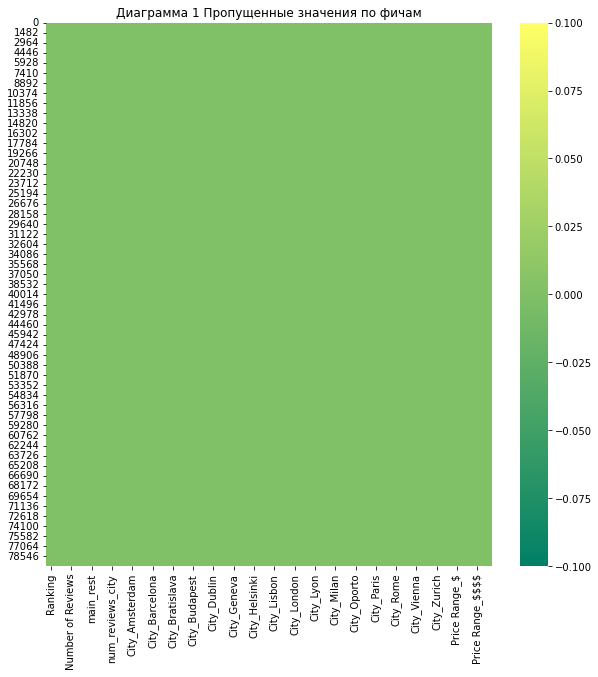

In [7]:
show_data_description(df_input)

## Обучение модели

In [4]:
%%time
column_list,feature_importances, y_test, y_pred = train_predict_model(df_input)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


## Вывод результатов работы модели

MAE: 0.21077999999999997


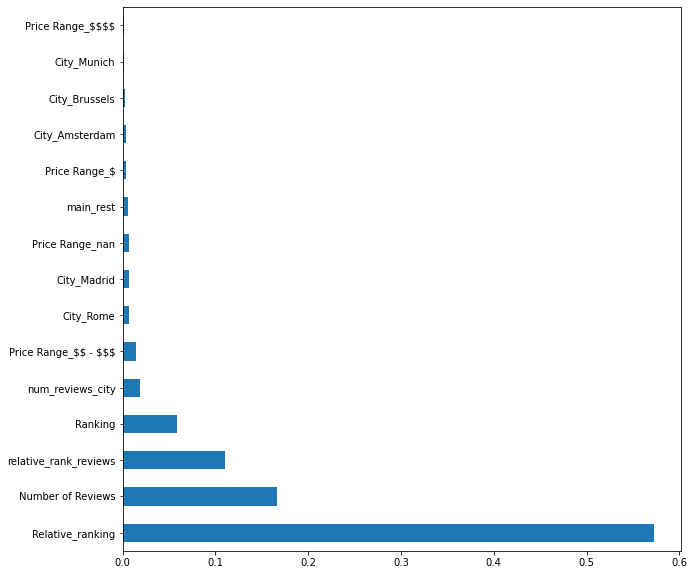

In [5]:
%%time
show_predict_result(column_list, feature_importances, y_test, y_pred)